In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import pandas as pd
from scipy.sparse import lil_matrix
import math

if tf.__version__.startswith('2'):
    tf.compat.v1.disable_eager_execution()

In [2]:
# Load data
ratings = pd.read_csv('ml-latest-small/ratings.csv').drop('timestamp', axis=1)

# Number of users
N = ratings.userId.nunique()
# Number of movies
D = ratings.movieId.nunique()

# Create a mapper from index to id
user2idx = dict(zip(ratings['userId'].unique(), range(ratings['userId'].nunique())))
movie2idx = dict(zip(ratings['movieId'].unique(), range(ratings['movieId'].nunique())))

# Create a mapper from id to idex
idx2user = dict(zip(range(ratings['userId'].nunique()), ratings['userId'].unique()))
idx2movie = dict(zip(range(ratings['movieId'].nunique()), ratings['movieId'].unique()))

# Convert id to index in dataframe
ratings['userId'] = ratings['userId'].apply(lambda x: user2idx[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: movie2idx[x])

# Shuffle the ratings table
data = shuffle(ratings)

# Init cutoff to split the data: 80%, 20%
cutoff = int(0.8*len(data))

# Split into train_set and test_set
train_set = data[:cutoff].reset_index().drop('index', axis=1)
test_set = data[cutoff:].reset_index().drop('index', axis=1)

print("Training set size:", train_set.shape[0])
print("Test set size:", test_set.shape[0])

Training set size: 80668
Test set size: 20168


In [3]:
# convert train_set and test_set to sparse representation

# init sparse matrices
train_lil = lil_matrix((N, D))
test_lil = lil_matrix((N, D))

def update_train(df):
    i = int( df.userId)
    j = int(df.movieId)
    train_lil[i,j] = df.rating
    
def update_test(df):
    i = int(df.userId)
    j = int(df.movieId)
    test_lil[i,j] = df.rating

train_set.apply(update_train, axis=1)
test_set.apply(update_test, axis=1)

train_lil = train_lil.tocsr()
test_lil = test_lil.tocsr()

mask = (train_lil > 0) * 1.0
mask_test = (test_lil > 0) * 1.0

In [4]:
def one_hot_encode(X, K):
    N, D = X.shape
    Y = np.zeros((N, D, K))
    for n, d in zip(*X.nonzero()):
        k = int(X[n,d]*2 - 1)
        Y[n,d,k] = 1
    return Y

def one_hot_mask(X, K):
    N, D = X.shape
    Y = np.zeros((N, D, K))
    for n, d in zip(*X.nonzero()):
        Y[n,d,:] = 1
    return Y

def convert_probs_to_ratings(probs):
    return probs.dot(np.arange(10) + 1) / 2

In [5]:
class RBM(object):
    def __init__(self, D, H, K):
        self.D = D # number of movies (visible units)
        self.H = H # number of hidden units
        self.K = K # number of element in the encoded rating vector
        self.build(D, H, K)


    def build(self, D, H, K):
        # weight
        self.W = tf.Variable(tf.random.normal(shape=(D, K, H)) * np.sqrt(2.0 / H))
        # hidden bias
        self.c = tf.Variable(np.zeros(H).astype(np.float32))
        # visible bias
        self.b = tf.Variable(np.zeros((D, K)).astype(np.float32))

        # data
        self.X_in = tf.compat.v1.placeholder(tf.float32, shape=(None, D, K))
        self.mask = tf.compat.v1.placeholder(tf.float32, shape=(None, D, K))

        # conditional probabilities
        V = self.X_in
        p_h_given_v = tf.nn.sigmoid(tf.tensordot(V, self.W, axes=[[1,2], [0,1]]) + self.c)
        self.p_h_given_v = p_h_given_v # save for later

        # draw a sample from p(h | v)
        r = tf.random.uniform(shape=tf.shape(input=p_h_given_v))
        H = tf.cast(r < p_h_given_v, dtype=tf.float32)

        # draw a sample from p(v | h)
        logits = tf.tensordot(H, self.W, axes=[[1], [2]]) + self.b
        cdist = tf.compat.v1.distributions.Categorical(logits=logits)
        X_sample = cdist.sample() # N x D
        X_sample = tf.one_hot(X_sample, depth=K) # N x D x K
        X_sample = X_sample * self.mask
        
        # build the objective
        objective = tf.reduce_mean(input_tensor=self.free_energy(self.X_in)) - tf.reduce_mean(input_tensor=self.free_energy(X_sample))
        self.train_op = tf.compat.v1.train.AdamOptimizer(1e-2).minimize(objective)

        # build the cost
        logits = self.forward_logits(self.X_in)
        self.cost = tf.reduce_mean(
            input_tensor=tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.stop_gradient(self.X_in),
                logits=logits,
            )
        )

        # to get the output
        self.output_visible = self.forward_output(self.X_in)

        initop = tf.compat.v1.global_variables_initializer()
        self.session = tf.compat.v1.Session()
        self.session.run(initop)

    def fit(self, X, mask, X_test, mask_test, epochs=50, batch_sz=200, show_fig=True):
        N, D = X.shape
        n_batches = N // batch_sz

        costs = []
        test_costs = []
        for i in range(epochs):
            print("epoch:", i)
            X, mask, X_test, mask_test = shuffle(X, mask, X_test, mask_test) # everything has to be shuffled accordingly
            for j in range(n_batches):
                x = X[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                m = mask[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                batch_one_hot = one_hot_encode(x, self.K)
                m = one_hot_mask(m, self.K)

                _, c = self.session.run(
                    (self.train_op, self.cost),
                    feed_dict={self.X_in: batch_one_hot, self.mask: m}
                )

            sse = 0
            test_sse = 0
            n = 0
            test_n = 0
            for j in range(n_batches):
                x = X[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                m = mask[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                xoh = one_hot_encode(x, self.K)
                probs = self.get_visible(xoh)
                xhat = convert_probs_to_ratings(probs)
                sse += (m * (xhat - x)*(xhat - x)).sum()
                n += m.sum()
                xt = X_test[j*batch_sz:(j*batch_sz + batch_sz)].toarray()
                mt = mask_test[j*batch_sz:(j*batch_sz + batch_sz)].toarray()

                test_sse += (mt * (xhat - xt) * (xhat - xt)).sum()
                test_n += mt.sum()
            c = math.sqrt(sse/n)
            ct = math.sqrt(test_sse/test_n)
            print("train rmse:", c)
            print("test rmse:", ct)
            costs.append(c)
            test_costs.append(ct)
        if show_fig:
            plt.figure(dpi=300)
            plt.plot(costs, label='train rmse')
            plt.plot(test_costs, label='test rmse')
            plt.xticks(np.arange(0, epochs, step=5))
            plt.ylabel("rmse")
            plt.xlabel("number of epochs")
            plt.title("Restricted Boltzmann Machine")
            plt.legend()
            plt.show()

    def free_energy(self, V):
        first_term = -tf.reduce_sum(input_tensor=tf.tensordot(V, self.b, axes=[[1,2], [0,1]]))
        second_term = -tf.reduce_sum(
            input_tensor=tf.nn.softplus(tf.tensordot(V, self.W, axes=[[1,2], [0,1]]) + self.c),
            axis=1
        )
        return first_term + second_term

    def forward_hidden(self, X):
        return tf.nn.sigmoid(tf.tensordot(X, self.W, axes=[[1,2], [0,1]]) + self.c)

    def forward_logits(self, X):
        Z = self.forward_hidden(X)
        return tf.tensordot(Z, self.W, axes=[[1], [2]]) + self.b

    def forward_output(self, X):
        return tf.nn.softmax(self.forward_logits(X))

    def transform(self, X):
        return self.session.run(self.p_h_given_v, feed_dict={self.X_in: X})

    def get_visible(self, X):
        return self.session.run(self.output_visible, feed_dict={self.X_in: X})

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.
epoch: 0
train rmse: 1.1524183385845583
test rmse: 1.1897804840420905
epoch: 1
train rmse: 0.9901722640574339
test rmse: 1.0551890427037258
epoch: 2
train rmse: 0.9210902651921767
test rmse: 1.0072598256365994
epoch: 3
train rmse: 0.8941834980478882
test rmse: 0.9965103175971352
epoch: 4
train rmse: 0.8737479733651415
test rmse: 0.9927171780728525
epoch: 5
train rmse: 0.8597085288691895
test rmse: 0.9920457906465229
epoch: 6
train rmse: 0.8469120203733866
test

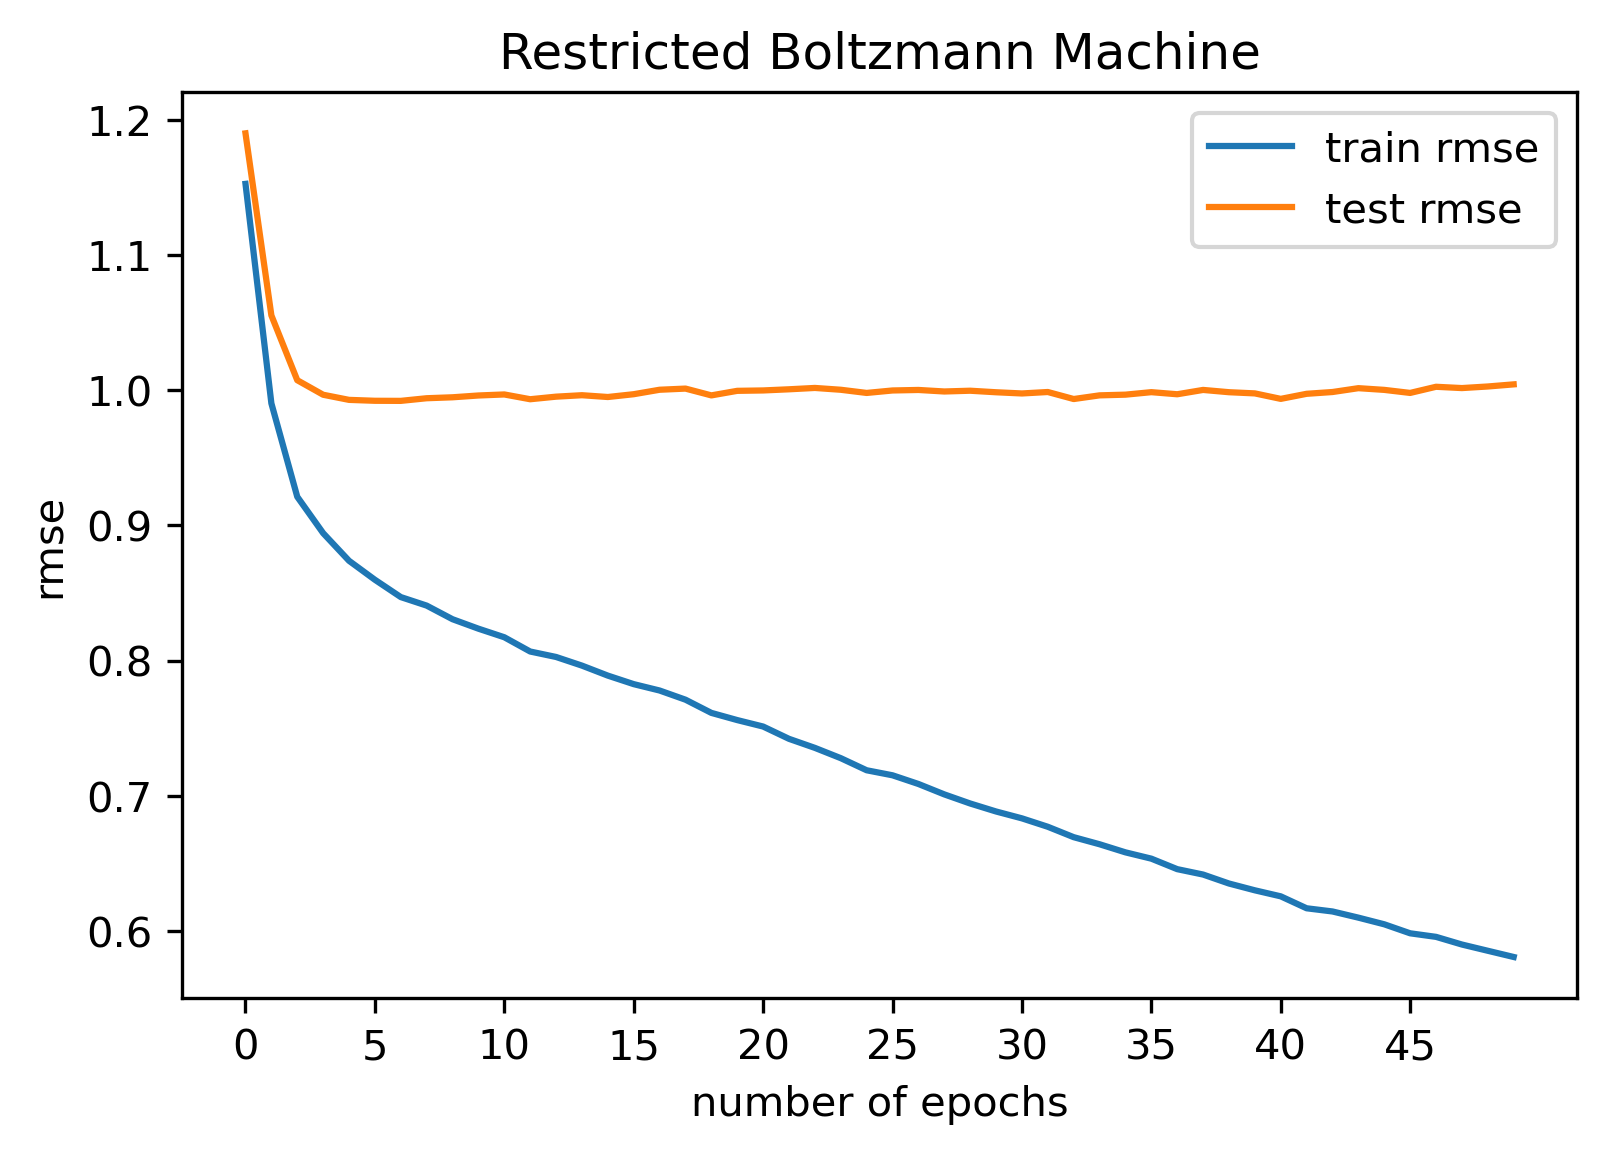

In [6]:
N, D = train_lil.shape
rbm = RBM(D, 40, 10)
rbm.fit(train_lil, mask, test_lil, mask_test)